In [1]:
# load all the csv's in this folder with 'percent_decrease' in the name
# max 30 characters in filename
# and return a list of DataFrames

import os
import pandas as pd
def load_csv_files_with_percent_decrease(folder_path):
    """
    Load all CSV files in the specified folder that contain 'percent_decrease' in their filename.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        list: A list of DataFrames loaded from the CSV files.
    """
    dataframes = []
    for filename in os.listdir(folder_path):
        if 'percent_decrease_T' in filename and filename.endswith('.csv'):
            # Ensure the filename is no longer than 30 characters
            if len(filename) > 30:
                continue
        
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    return dataframes


In [2]:
folder_path = r'C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\5. Python'

dataframes = load_csv_files_with_percent_decrease(folder_path)

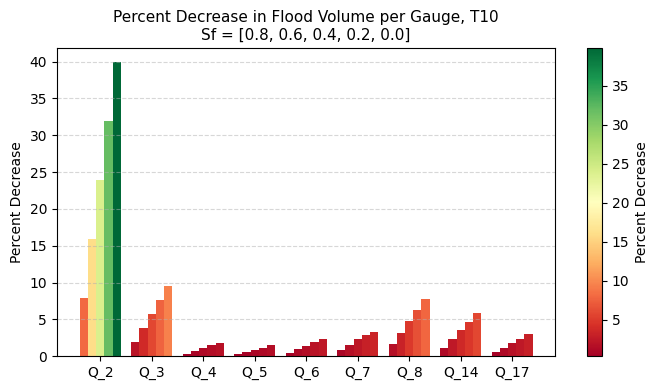

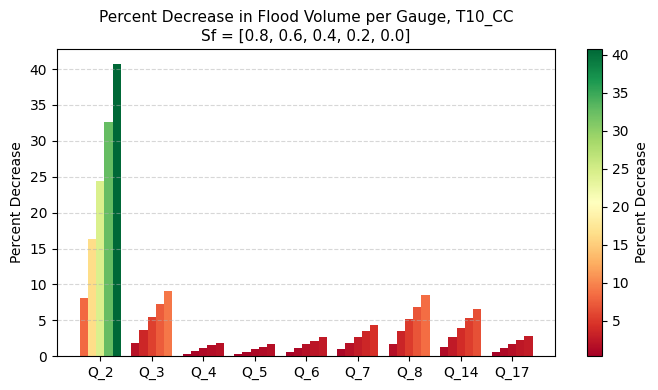

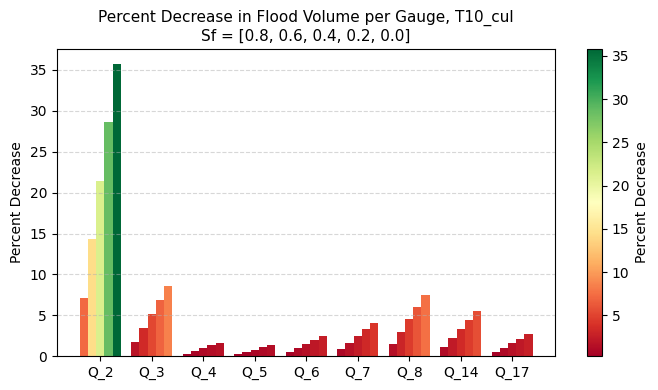

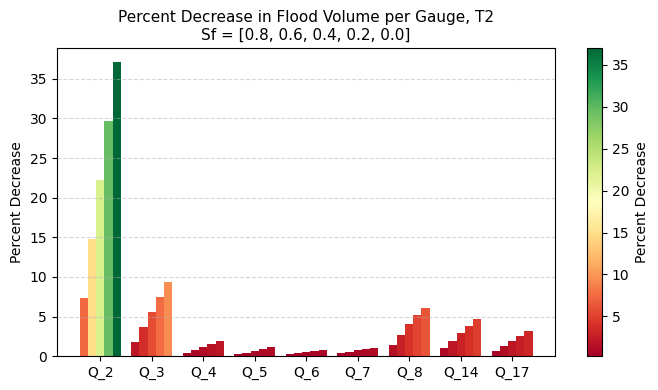

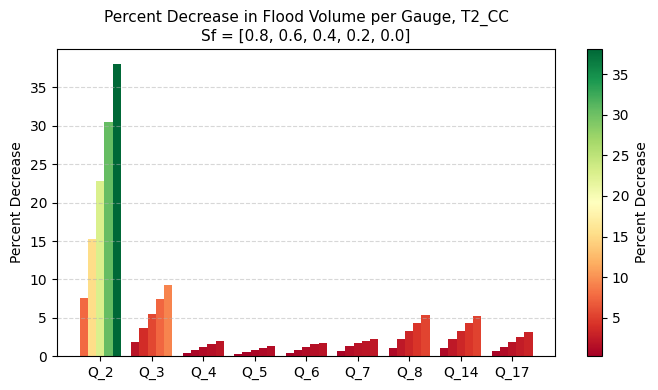

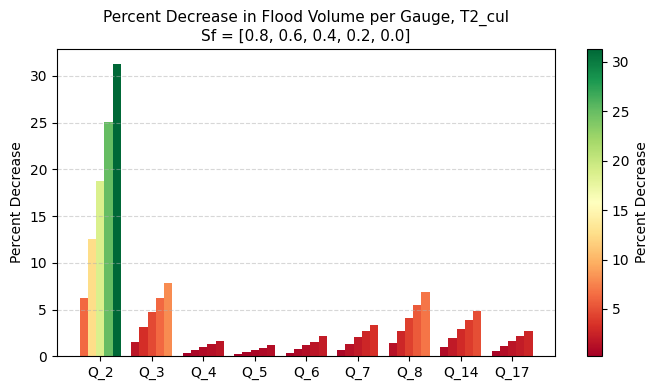

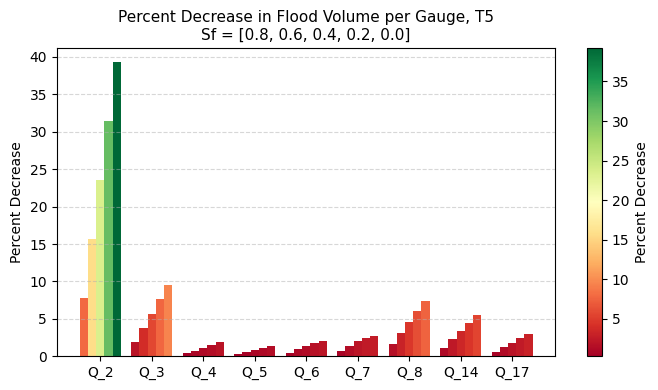

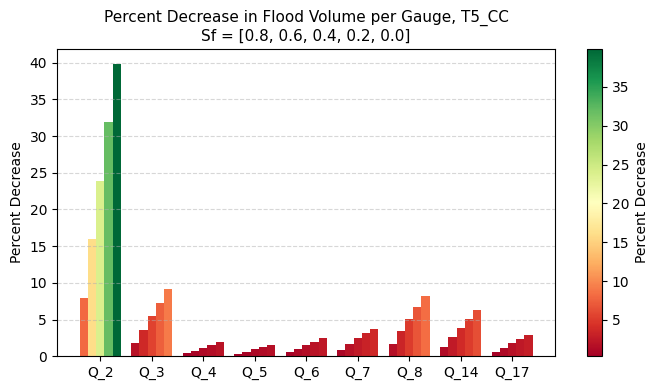

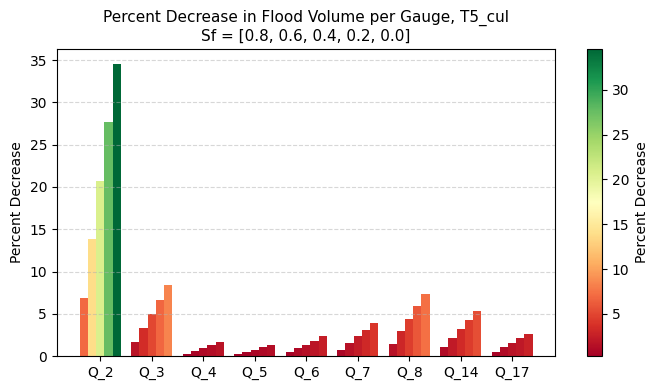

In [17]:
import matplotlib.pyplot as plt
import numpy as np

scalefactors = [0.8, 0.6, 0.4, 0.2, 0.0]  # Example scale factors

for i, df in enumerate(dataframes):
    df['scale factor'] = scalefactors
    if 'index' in df.columns:
        df = df.drop(columns=['index'])
    gauge_cols = [col for col in df.columns if col != 'scale factor' and col != 'scenario']
    scalefactors = df['scale factor'].values

    df[gauge_cols] = df[gauge_cols].apply(pd.to_numeric, errors='coerce')
    data_matrix = df[gauge_cols].values.astype(float)  # shape: (num_scales, num_gauges)

    x = np.arange(len(gauge_cols))
    bar_width = 0.8 / len(scalefactors)
    cmap = plt.get_cmap('RdYlGn')  # Use a colormap that goes from red to yellow to green
    norm = plt.Normalize(np.nanmin(data_matrix), np.nanmax(data_matrix))

    fig, ax = plt.subplots(figsize=(7, 4))
    for idx, scale in enumerate(scalefactors):
        # Color each bar by its percent decrease value
        bar_colors = cmap(norm(data_matrix[idx, :]))
        ax.bar(
            x + idx * bar_width,
            data_matrix[idx, :],
            width=bar_width,
            color=bar_colors,
            label=f'Scale {scale:.2f}'
        )

    # Create custom x-tick labels to indicate gauge and group of scale factors
    xtick_positions = x + bar_width * (len(scalefactors) - 1) / 2
    xtick_labels = [f"{gauge}" for gauge in gauge_cols]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

    #ax.set_xlabel('Gauge (each group: bars left→right = scale factors)')
    ax.set_ylabel('Percent Decrease')

    #print(df)

    scenario_name = str(df['scenario'].loc[0]) if 'scenario' in df.columns else f"DataFrame {i+1}"
    ax.set_title(f'Percent Decrease in Flood Volume per Gauge, {scenario_name}\nSf = [0.8, 0.6, 0.4, 0.2, 0.0]', fontsize=11)
    #ax.set_title(f'Percent Decrease per Gauge for all Scale Factors (Scenario {df["scenario"].iloc[1]})')
    #ax.legend(title='Scale Factor')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Percent Decrease')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'percent_decrease_per_gauge_{scenario_name}.png', dpi=300)   
    plt.show()


In [5]:
total_df = pd.read_csv(os.path.join(folder_path, 'percent_decrease_flood_volume_summed.csv'))

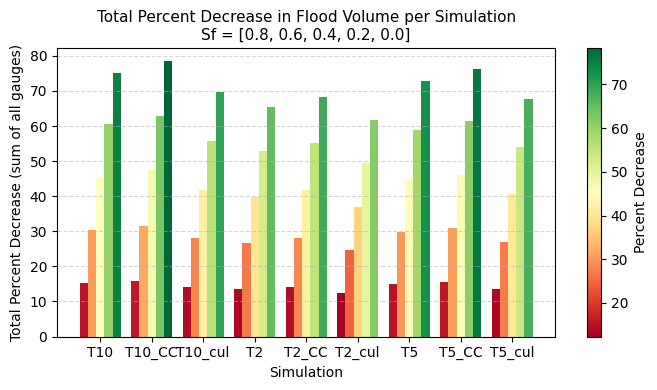

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure all gauge columns are numeric
gauge_cols = [col for col in total_df.columns if col not in ['simulation', 'scale factor']]
total_df[gauge_cols] = total_df[gauge_cols].apply(pd.to_numeric, errors='coerce')

simulations = sorted(total_df['simulation'].astype(str).unique())
scalefactors = [0.8, 0.6, 0.4, 0.2, 0.0]  # Or: sorted(total_df['scale factor'].unique(), reverse=True)
bar_width = 0.8 / len(scalefactors)
x = np.arange(len(simulations))

cmap = plt.get_cmap('RdYlGn')
# Compute the min/max over all summed values for color normalization
all_sums = []
for scale in scalefactors:
    for sim in simulations:
        row = total_df[(total_df['simulation'].astype(str) == sim) & (total_df['scale factor'] == scale)]
        if not row.empty:
            all_sums.append(row[gauge_cols].sum(axis=1).values[0])
norm = plt.Normalize(np.nanmin(all_sums), np.nanmax(all_sums))

fig, ax = plt.subplots(figsize=(7, 4))

for idx, scale in enumerate(scalefactors):
    values = []
    for sim in simulations:
        row = total_df[(total_df['simulation'].astype(str) == sim) & (total_df['scale factor'] == scale)]
        if not row.empty:
            values.append(row[gauge_cols].sum(axis=1).values[0])
        else:
            values.append(np.nan)
    bar_colors = cmap(norm(values))
    ax.bar(x + idx * bar_width, values, width=bar_width, color=bar_colors, label=f'Scale {scale:.2f}')

xtick_positions = x + bar_width * (len(scalefactors) - 1) / 2
ax.set_xticks(xtick_positions)
ax.set_xticklabels(simulations, rotation=0, ha='center')
ax.set_xlabel('Simulation')
ax.set_ylabel('Total Percent Decrease (sum of all gauges)')
ax.set_title('Total Percent Decrease in Flood Volume per Simulation\nSf = [0.8, 0.6, 0.4, 0.2, 0.0]', fontsize=11)
#ax.legend(title='Scale Factor')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Percent Decrease')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('total_percent_decrease_in_flood_volume_per_simulation.png')
plt.show()